# Evaluation for Kirk Experiment

**WARNING** concat (all) here equals concat (non-static) because all other context features than pole length
and gravity are masked.

In [1]:
import sys
from omegaconf import OmegaConf, DictConfig
from typing import Union, Dict, Optional
from pathlib import Path
from experiments.evaluation.utils import recover_traincfg_from_wandb

sys.path.append("../..")
folder_train = "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2022-07-01/14-14-50_benchmark_train/"
folder_eval = (
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-07-06/17-21-44"
)
folder_eval = "/home/benjamin/Dokumente/code/tmp/CARL/multirun/2022-07-07/07-57-17/"


# folder_train = "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2022-10-27/17-41-56_benchmark_train"
# folder_eval = "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-10-28/08-35-10"

folder_eval = "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-12-21/20-58-07"  # rerun


In [11]:
from rich import print as printr
from rich.progress import track
import pickle
from pathlib import Path
import numpy as np
import ast
import pandas as pd
from tqdm import tqdm
from wandb.sdk.wandb_helper import parse_config
from experiments.common.utils.json_utils import lazy_json_load
from experiments.evaluation.run_evaluation import find_multirun_paths


def load_wandb_table(fn: Union[str, Path]) -> pd.DataFrame:
    data = lazy_json_load(fn)
    data = pd.DataFrame(data=np.array(data["data"]), columns=data["columns"])
    return data


reload_rpc: bool = False

fn_config = ".hydra/config.yaml"
fn_wbsummary = "wandb/latest-run/files/wandb-summary.json"
fn_wbconfig = "wandb/latest-run/files/config.yaml"
rpc_fn = Path("rpc" + Path(folder_eval).name + ".csv")
if not rpc_fn.is_file():
    reload_rpc = True

paths = find_multirun_paths(result_dir=folder_eval)

if reload_rpc:
    rpc_list = []
    for i, p in tqdm(enumerate(paths), total=len(paths)):
        p = Path(p)
        fn_cfg = p / fn_config
        fn_wbsum = p / fn_wbsummary
        fn_wbcfg = p / fn_wbconfig
        if not fn_wbcfg.is_file() or not fn_wbsum.is_file() or not fn_cfg.is_file():
            continue
        cfg = OmegaConf.load(fn_cfg)
        traincfg = recover_traincfg_from_wandb(fn_wbcfg)
        summary = lazy_json_load(fn_wbsum)

        if traincfg is not None:
            mode = traincfg.kirk_evaluation_protocol.mode
        else:
            mode = cfg.kirk_evaluation_protocol.mode
        if "average_return" in summary:
            average_return = summary["average_return"]
        else:
            average_return = None

        if mode is None or average_return is None:
            print(f"Skip. Mode {mode}, average_return {average_return}")
            continue

        distribution_type = cfg.kirk_evaluation_protocol.distribution_type
        entry = {
            "mode": mode,
            "distribution_type": distribution_type,
            "average_return": average_return,
        }

        path_to_table = fn_wbsum.parent / summary["return_per_context_table"]["path"]
        return_per_context = load_wandb_table(path_to_table)

        contexts_path = fn_wbsum.parent / summary["evalpost/contexts"]["path"]
        contexts = load_wandb_table(contexts_path)

        visibility = traincfg.wandb.group

        context_ids = return_per_context["context_id"].apply(int).to_list()
        contexts_to_table = pd.DataFrame([contexts.iloc[cidx] for cidx in context_ids])
        for col in contexts_to_table.columns:
            return_per_context[col] = contexts_to_table[col].to_numpy()
        n = len(return_per_context)
        return_per_context["mode"] = [mode] * n
        return_per_context["distribution_type"] = [distribution_type] * n
        return_per_context["average_return"] = [average_return] * n
        return_per_context["visibility"] = visibility
        rpc_list.append(return_per_context)

        # if i == 10:
        #     break

if reload_rpc:
    df_rpc = pd.concat(rpc_list)
    df_rpc.to_csv(rpc_fn)
else:
    df_rpc = pd.read_csv(rpc_fn)

df_rpc["visibility"][df_rpc["visibility"] == "concat (all)"] = "concat (non-static)"

/tmp/ipykernel_28567/3230700120.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rpc["visibility"][df_rpc["visibility"] == "concat (all)"] = "concat (non-static)"


In [3]:
# Plotting definitions
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

vmin = 350  # df_rpc["return"].min()
vmax = 500  # df_rpc["return"].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


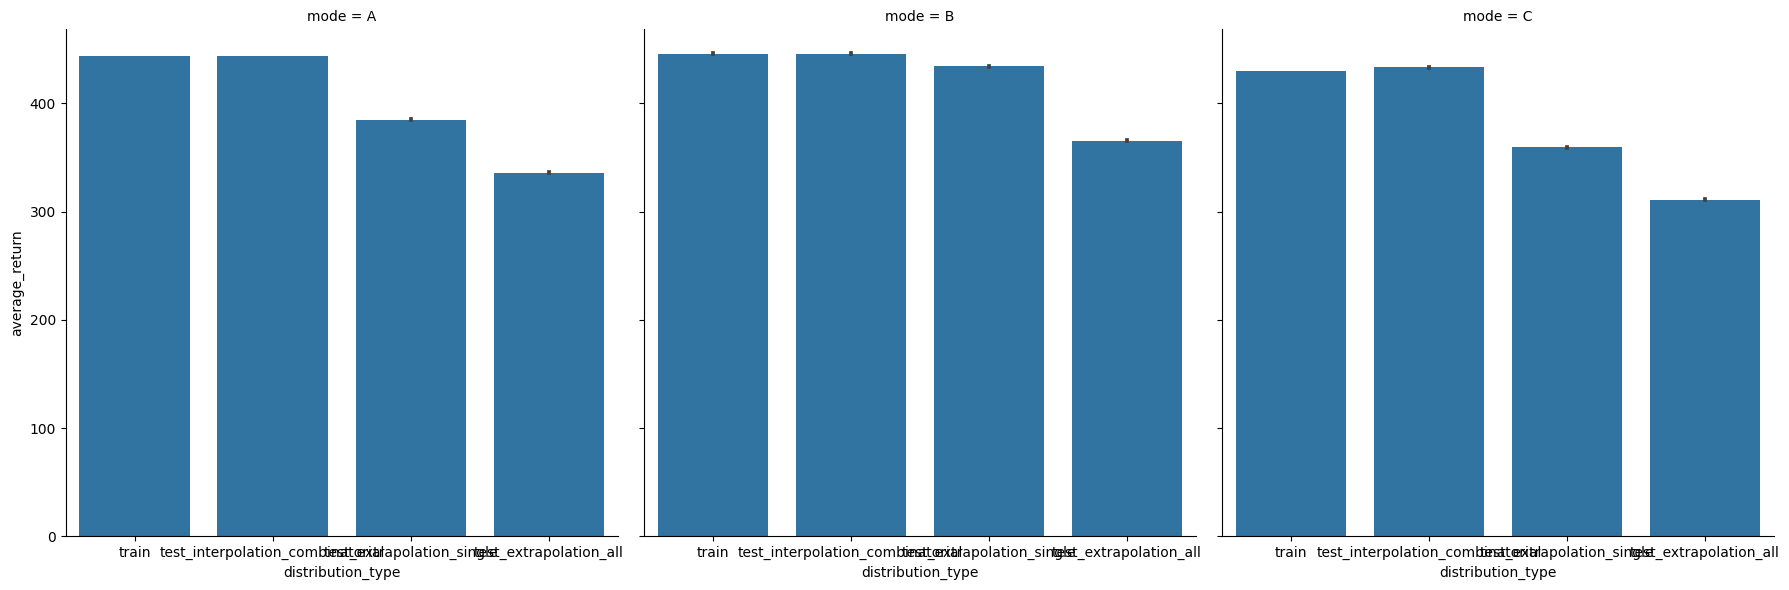

In [19]:
grid = sns.FacetGrid(df_rpc, col="mode", height=6)
grid.map(sns.barplot, "distribution_type", "average_return")

## Plot Evaluation Protocol Modes

/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/experiments/evaluation/../../carl/envs/mario/__init__.py:7: UserWarning: Could not load CARLMarioEnv which is probably not installed (No module named 'cv2').
  warnings.warn(f"Could not load CARLMarioEnv which is probably not installed ({e}).")
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/glfw/__init__.py:906: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


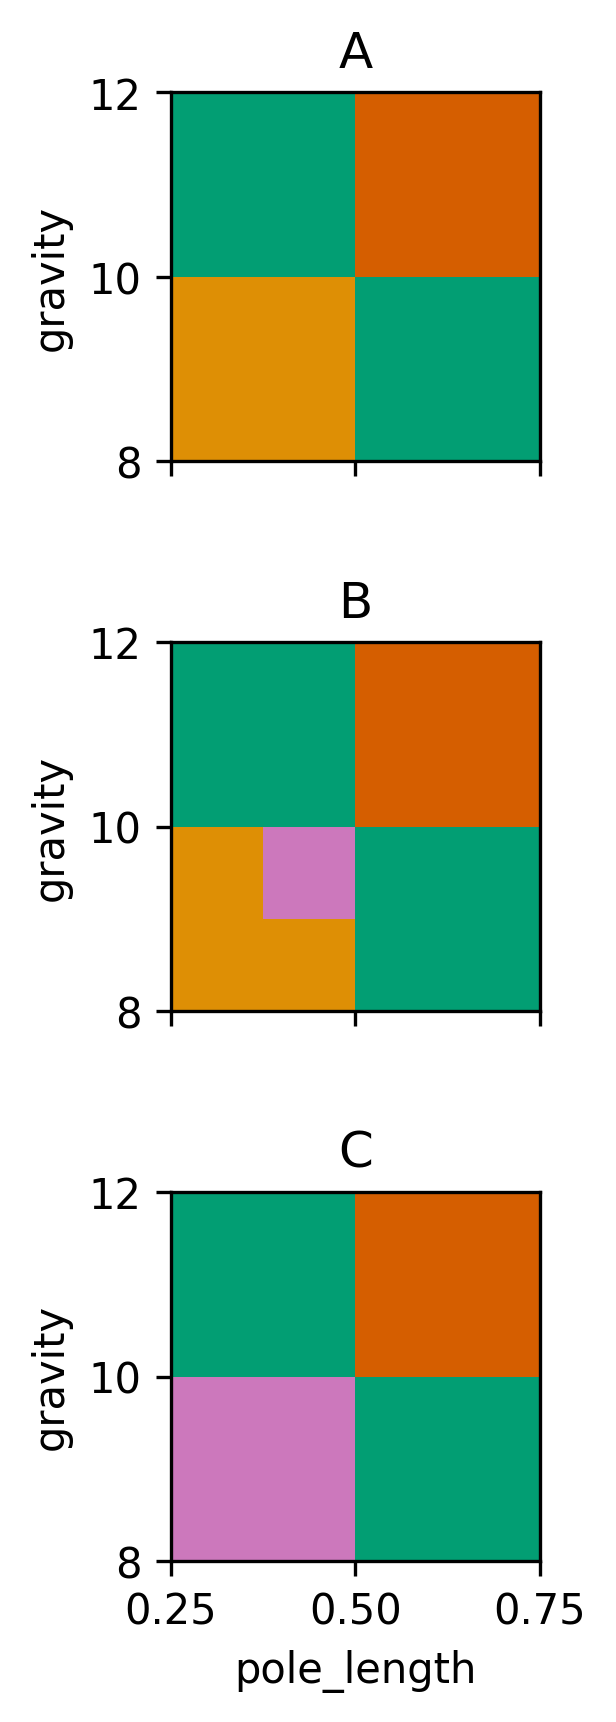

In [4]:
from hydra.utils import instantiate
from experiments.evaluation_protocol.plot_evaluate_on_protocol import get_ep_mplpatches
from experiments.evaluation_protocol.plot_traintest_distributions import (
    get_legend_elements,
)

traincfg = recover_traincfg_from_wandb(Path(folder_eval) / "0" / fn_wbconfig)
context_features = [
    instantiate(config=cf) for cf in traincfg.kirk_evaluation_protocol.context_features
][::-1]

modes = r"ABC"

fig = plt.figure(figsize=(2, 6), dpi=300)
axes = fig.subplots(nrows=len(modes), ncols=1, sharex=True, sharey=True)
for i, mode in enumerate(modes):
    ax = axes[i]
    patches = get_ep_mplpatches(
        context_features=context_features,
        draw_frame=False,
        mode=mode,
        patch_kwargs=dict(linewidth=0),
    )
    for patch in patches:
        ax.add_patch(patch)
    ax.set_box_aspect(1)

    cf0, cf1 = context_features

    # Set ax lims
    xlim = (cf0.lower, cf0.upper)
    ylim = (cf1.lower, cf1.upper)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

    # Add axis descriptions
    ax.set_ylabel(cf1.name)
    if i == len(modes) - 1:
        ax.set_xlabel(cf0.name)
    ax.set_title(mode)
    yticks = [cf1.lower, cf1.mid, cf1.upper]
    ax.set_yticks(yticks)

# Add legend
# legend_elements = get_legend_elements()

fig.set_tight_layout(True)
fig_fn = Path("./data/kirk_distribution_regions.png")
fig_fn.parent.mkdir(exist_ok=True, parents=True)
fig.savefig(fig_fn, dpi=300, bbox_inches="tight")
plt.show()

# Plot Heatmaps
  (0, 0) origin       9     gravity     11
    X------------------->
    |  0.6
    |
    |
    |  pole_length
    |
    |
    |
    V  0.4

discretizer
{'gravity': (8.0, 12.0, 40), 'pole_length': (0.25, 0.75, 40)}

(3, 3)
398.2851700246242 53.98715890165253
376.8898429056717 81.94783089981165
414.58445959047543 42.35776257211084
410.6346933811802 63.13673327318543
313.4920512115043 93.59693569321063
408.0669810975791 51.70531313920384
380.35215708979865 55.565845689689034
311.08213383377193 92.88262447220875
419.33425014462335 49.80092379272524


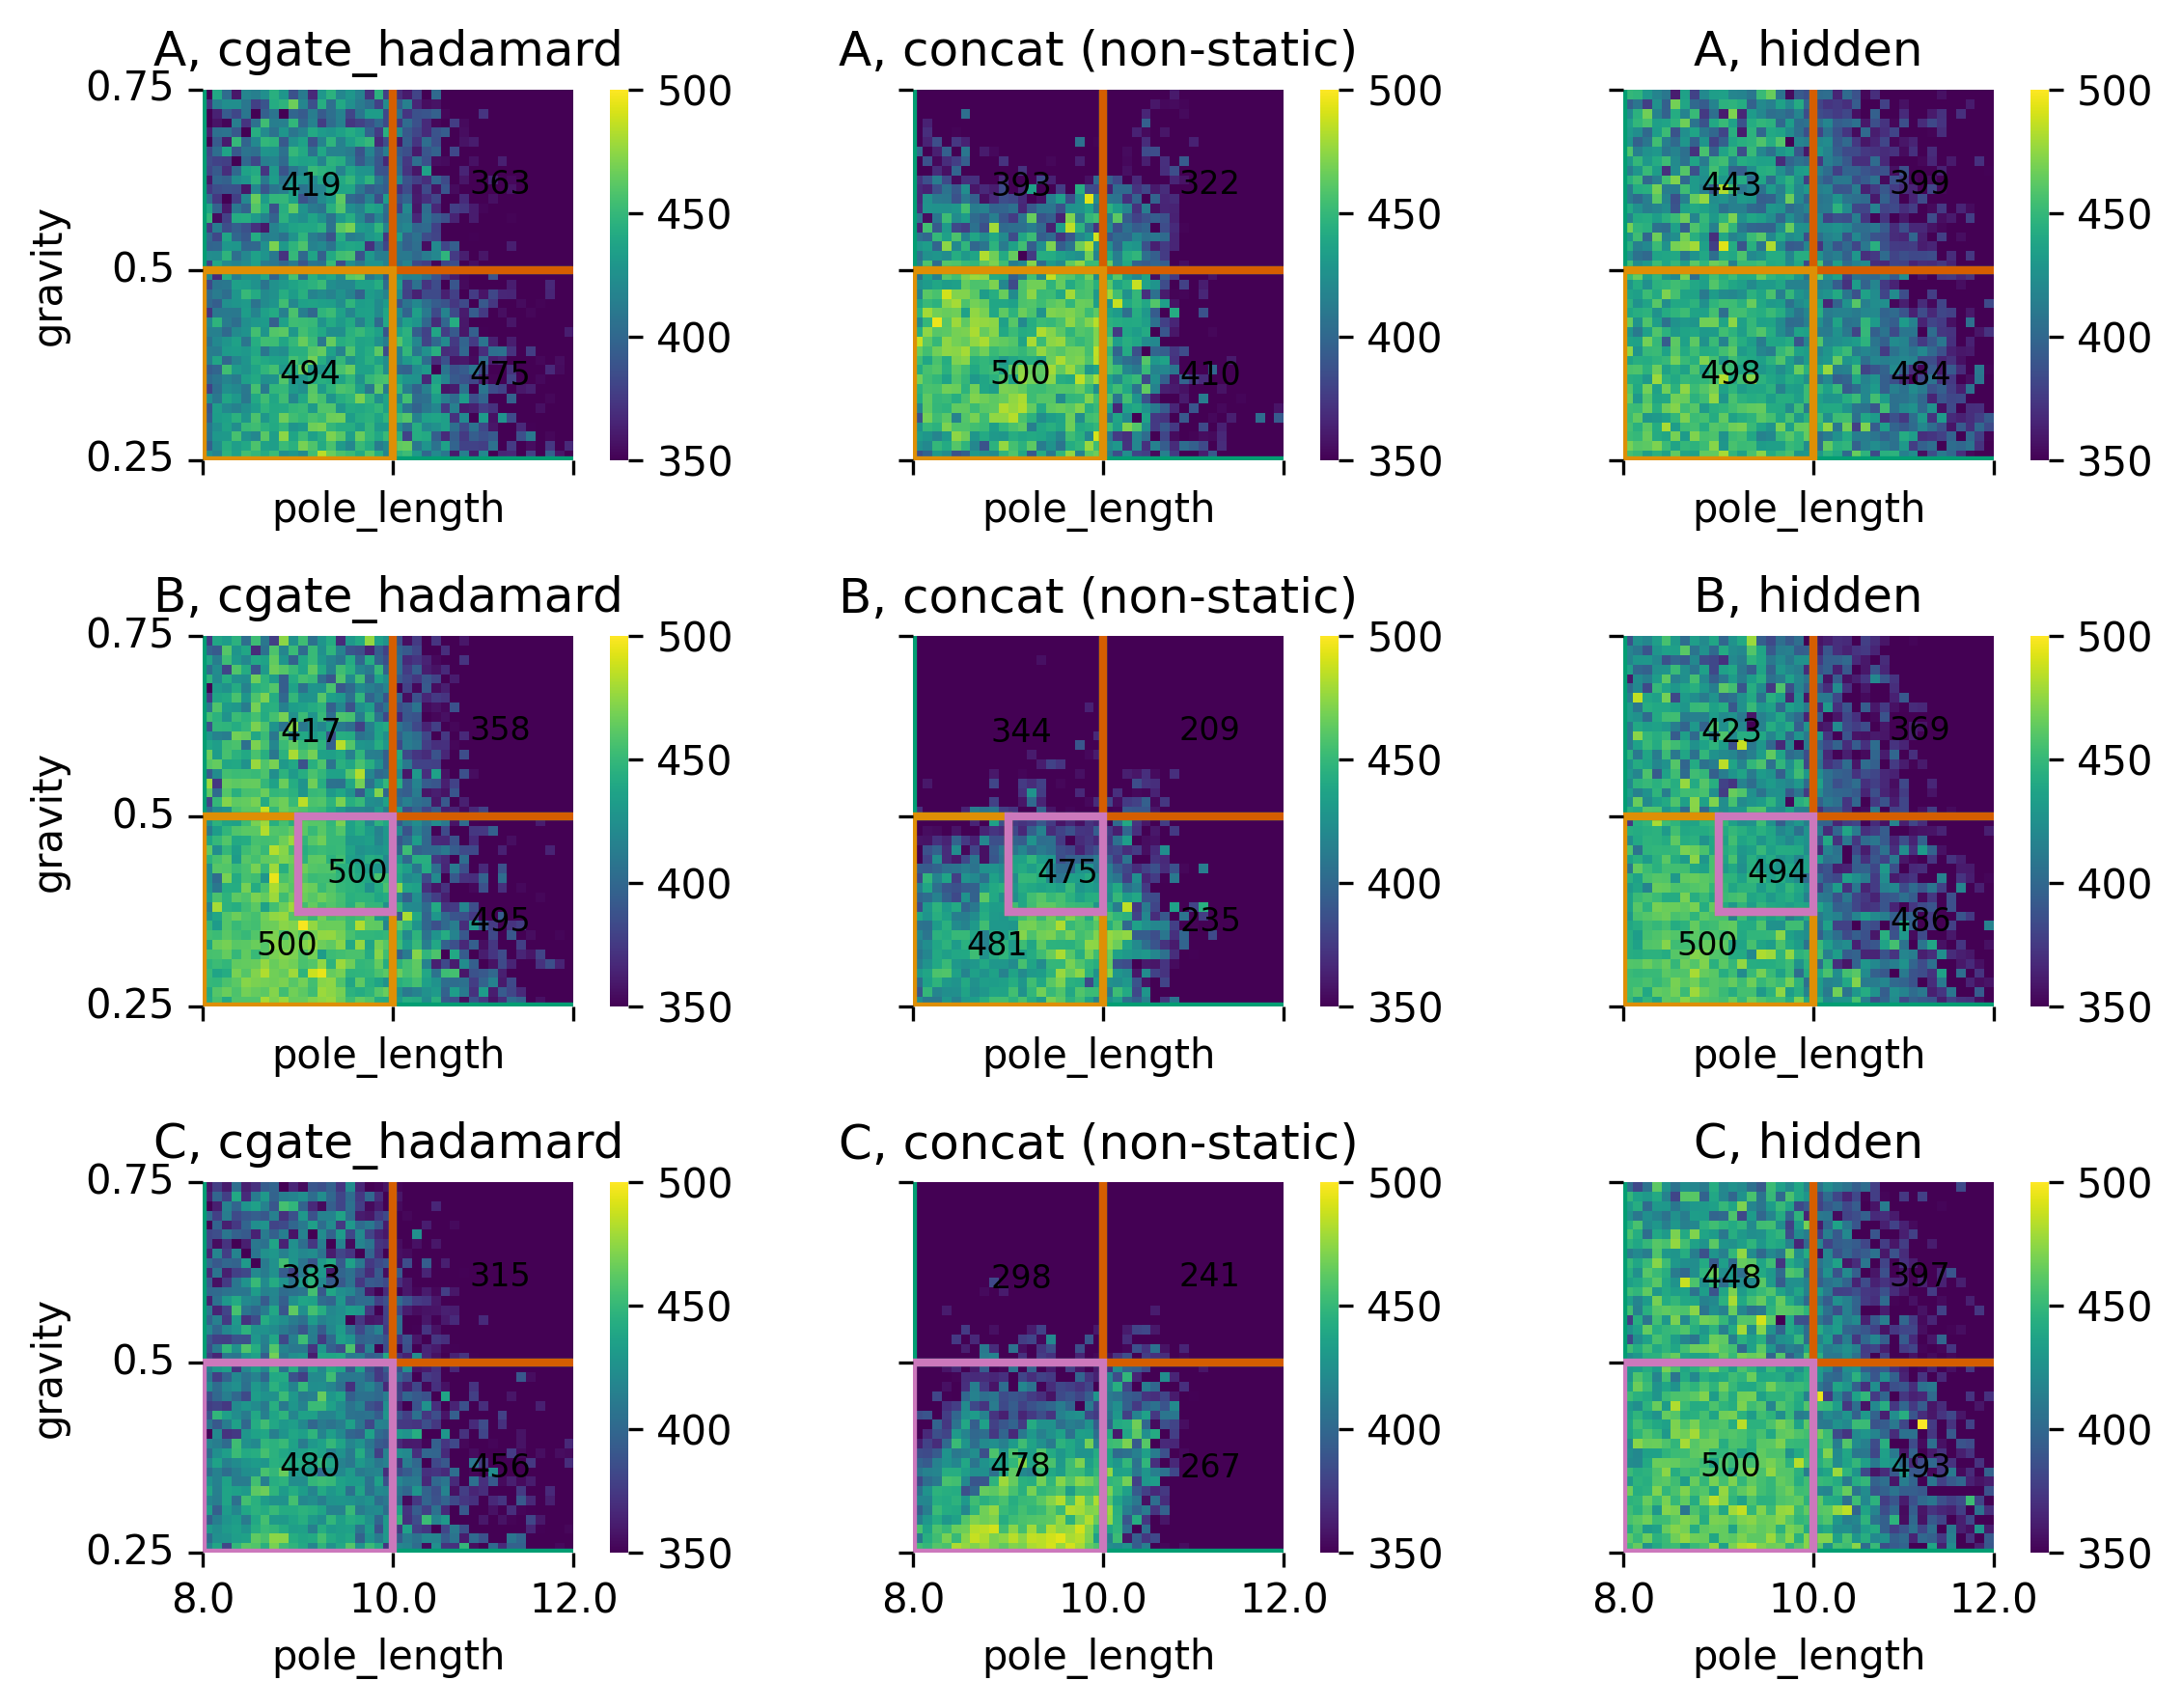

In [20]:
from copy import copy
from hydra.utils import instantiate
from experiments.evaluation_protocol.plot_evaluate_on_protocol import get_ep_mplpatches
import scipy

# Get train configuration
traincfg = recover_traincfg_from_wandb(Path(folder_eval) / "0" / fn_wbconfig)

# Load context features
context_features = [
    instantiate(config=cf) for cf in traincfg.kirk_evaluation_protocol.context_features
]

# Set plot params
plt.rcParams["axes.grid"] = False
always_add_xlabel = True
add_numbers_on_heatmap = True
annot_with_std = False
cmap = copy(plt.cm.viridis)
cmap.set_bad(color="k")

df = df_rpc

# Filter 
filter_distribution_types = [
    "train",
    # "test_interpolation",
    # "test_interpolation_combinatorial",
    # "test_extrapolation_single",
    # "test_extrapolation_all"
]
for fil in filter_distribution_types:
    df = df[df["distribution_type"] != fil]

# Discretize context
n_bins = 40
discretizer = {v.name: (v.lower, v.upper, n_bins) for v in context_features}
printr("discretizer", discretizer)
# discretizer = {
#     "pole_length": (0.4, 0.8, n_bins),  # rows of heatmap
#     "gravity": (9, 11, n_bins),  # cols of heatmap
# }

context_features_bins = []
for cf in context_features:
    cf = copy(cf)

    def transform(v: float) -> float:
        """Noramalize context feature value to [0,1] depending on lower and upper
        bound.

        Parameters
        ----------
        v : float
            Context feature value

        Returns
        -------
        float
            Normalized context feature value
        """
        return (v - cf.lower) / (cf.upper - cf.lower) * n_bins

    # Transform distinctive context feature values
    vals_to_discretize = [cf.lower, cf.lower_constraint, cf.mid, cf.upper]
    transformed = [transform(v) for v in vals_to_discretize]
    cf.lower, cf.lower_constraint, cf.mid, cf.upper = transformed

    # Add context feature with normalized bounds
    context_features_bins.append(cf)

# Define groups and plot layout
group_keys = ["mode", "visibility"]  # , "distribution_type"]
groups = df.groupby(group_keys)

fig = plt.figure(figsize=(8, 6), dpi=300)
axes = fig.subplots(
    nrows=df[group_keys[0]].nunique(),  # row: mode
    ncols=df[group_keys[1]].nunique(),  # col: visibility
    sharex=True,
    sharey=True,
)
print(axes.shape)
# For each mode + visibility
for i, (group_id, group_df) in enumerate(groups):
    ax = axes.flatten()[i]

    # Get mode
    mode = group_id[group_keys.index("mode")]

    # For each context feature
    # Go through group and discretize
    for key, args in discretizer.items():
        bins = np.linspace(*args)
        ids = np.digitize(group_df[key].to_numpy(), bins=bins, right=False) - 1
        discretized = [bins[i] for i in ids]
        group_df[key + "_discrete"] = discretized
        group_df[key + "_id"] = ids

    # Reduce dataframe by average over same contexts
    reduced = group_df.groupby([k + "_id" for k in discretizer.keys()]).mean(numeric_only=True)
    # printr(reduced.iloc[0])
    heatmap = np.zeros((n_bins - 1, n_bins - 1))
    # printr(heatmap.shape)
    # printr(reduced["gravity_discrete"].nunique())

    for idx in reduced.index:
        row = reduced.loc[idx]
        ret = row["return"]
        heatmap[idx] = ret

    hm_mean = np.mean(heatmap[heatmap != 0])
    hm_mean = scipy.stats.trim_mean(heatmap[heatmap != 0], proportiontocut=0.25, axis=None)
    hm_std = np.std(heatmap[heatmap != 0])
    print(hm_mean, hm_std)

    heatmap[heatmap == 0] = np.nan

    patches = get_ep_mplpatches(
        context_features=context_features_bins,
        draw_frame=True,
        mode=mode,
        patch_kwargs=dict(linewidth=2),
    )

    ax = sns.heatmap(heatmap, ax=ax, cmap=cmap, norm=norm)
    ax.set_box_aspect(1)
    ax.invert_yaxis()

    # ticks
    cf0, cf1 = context_features_bins
    xticks = [cf0.lower, cf0.mid, cf0.upper - 1]
    yticks = [cf1.lower, cf1.mid, cf1.upper - 1]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    cf0, cf1 = context_features
    xticklabels = [cf0.lower, cf0.mid, cf0.upper]
    yticklabels = [cf1.lower, cf1.mid, cf1.upper]
    ax.set_xticklabels(xticklabels, rotation=0)
    ax.set_yticklabels(yticklabels, rotation=0)

    # Add numbers onto region
    if add_numbers_on_heatmap:
        distr_types = [
            "test_interpolation",
            "test_interpolation_combinatorial",
            "test_extrapolation_single",
            "test_extrapolation_all",
        ]
        subgroups = group_df.groupby("distribution_type")
        for j, (subgroup_id, subgroup_df) in enumerate(subgroups):
            xid = list(discretizer.keys())[0]
            xv = discretizer[xid]
            yid = list(discretizer.keys())[1]
            yv = discretizer[yid]

            def annotate(df):
                region_mean = df["return"].mean()
                region_mean = scipy.stats.trim_mean(df["return"], proportiontocut=0.25, axis=None)
                # region_mean = df["return"].median()
                region_std = df["return"].std()
                text = f"{region_mean:.0f}"
                if annot_with_std:
                    text += f"±{region_std:.0f}"

                x = df[xid].mean()
                y = df[yid].mean()

                def map_to_pixels(x, l, u, n_bins):
                    return (x - l) / (u - l) * n_bins

                n_bins = len(bins)
                x = map_to_pixels(x, xv[0], xv[1], n_bins)
                y = map_to_pixels(y, yv[0], yv[1], n_bins)

                x_offset = -2
                if annot_with_std:
                    x_offset -= 2
                ax.text(x=x + x_offset, y=y - 2, s=text, fontsize=8)
                return text

            if subgroup_id == "test_extrapolation_single":
                mid = (xv[1] + xv[0]) / 2
                df = subgroup_df[subgroup_df[xid] < mid]
                text = annotate(df)
                text = annotate(subgroup_df[subgroup_df[xid] > mid])
            else:
                text = annotate(subgroup_df)

    # Add ylabel to first column
    if i % axes.shape[0] == 0:
        ax.set_ylabel(list(discretizer.keys())[0])

    # Add xlabel to last row
    if i >= np.prod(axes.shape) - axes.shape[1] or always_add_xlabel:
        ax.set_xlabel(list(discretizer.keys())[1])

    # # Remove colorbars except for last column
    # if (i + 1) % axes.shape[0] == 0:
    #     from rich import inspect
    #     inspect(ax)

    # ax.axis("off")
    for patch in patches:
        ax.add_patch(patch)
    ax.set_title(", ".join(group_id))

fig.set_tight_layout(True)
fig_fn = Path("./data/kirk_heatmaps.png")
fig_fn.parent.mkdir(exist_ok=True, parents=True)
fig.savefig(fig_fn, bbox_inches="tight")
plt.show()

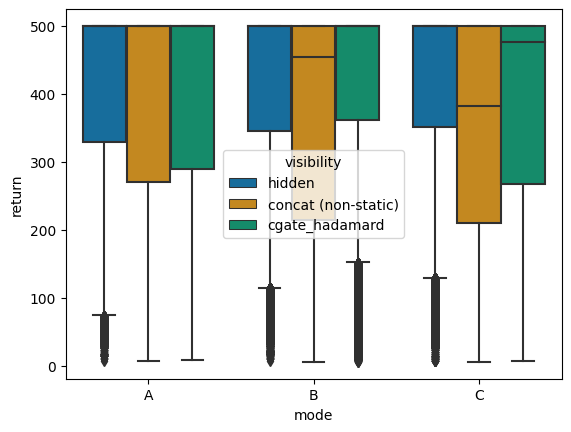

In [21]:
# need defs from cell before
# grid = sns.FacetGrid(df, col="mode", height=4)
# grid.map(sns.barplot, "visibility", "return", color='cornflowerblue')
# for rows in grid.axes:
#     for ax in rows:
#         ax.set_ylim(440, vmax)

df = df_rpc
ax = sns.boxplot(data=df, x="mode", y="return", hue="visibility", palette="colorblind")
# ax.set_ylim(440, vmax)

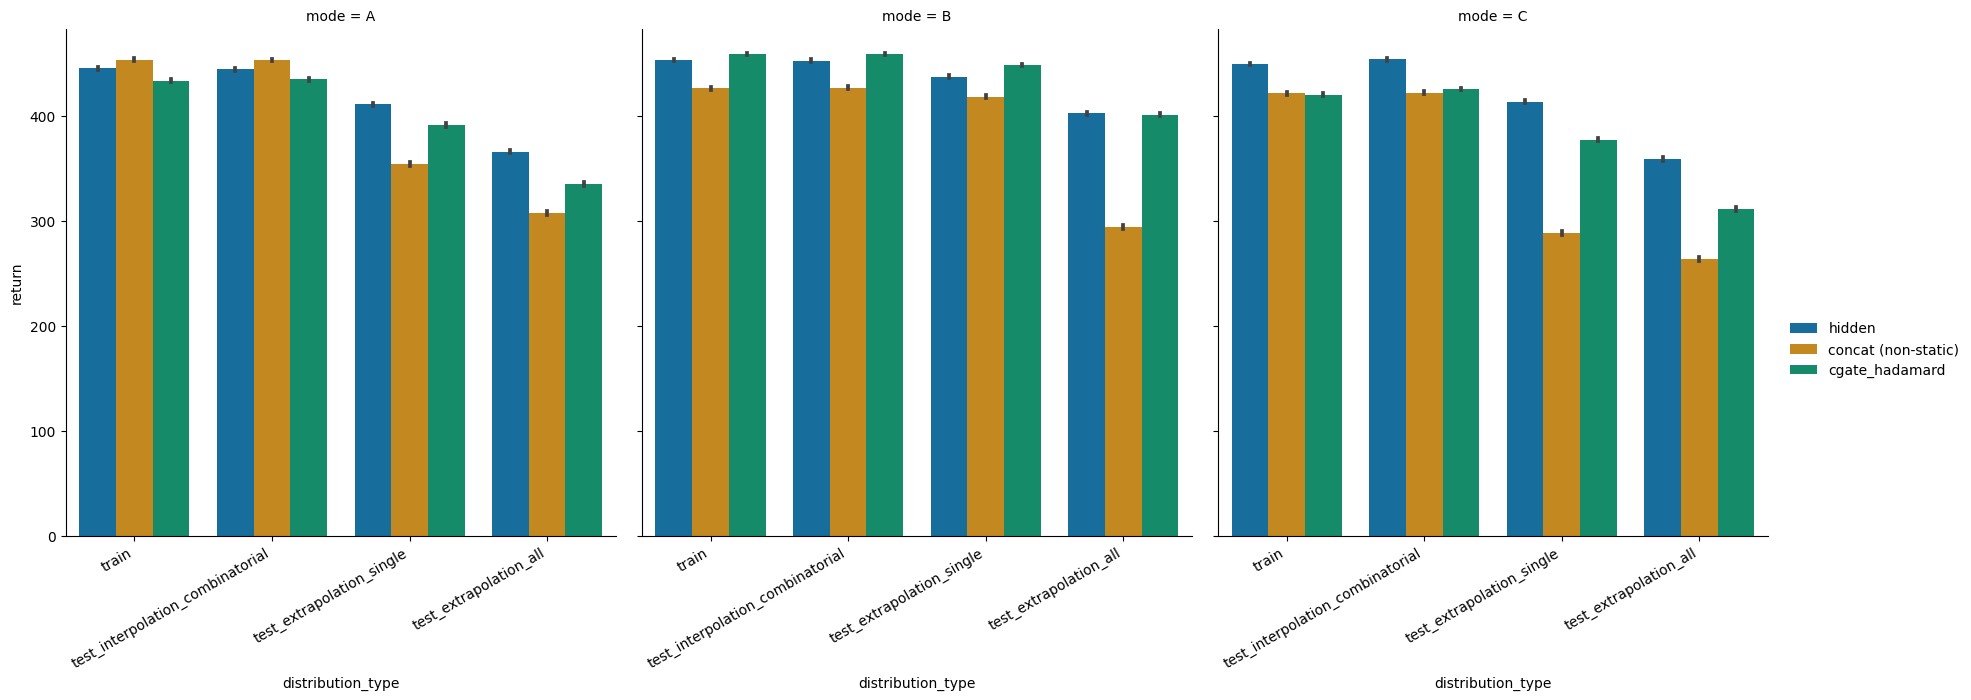

In [15]:
df = df_rpc
grid = sns.FacetGrid(df, col="mode", height=6, legend_out=True)
grid.map_dataframe(
    sns.barplot,
    x="distribution_type",
    y="return",
    hue="visibility",
    palette="colorblind",
)
# grid.set(ylim=(420, None))
for axes in grid.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30, horizontalalignment="right")
grid.add_legend()

/tmp/ipykernel_28567/4088825012.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30, horizontalalignment="right")


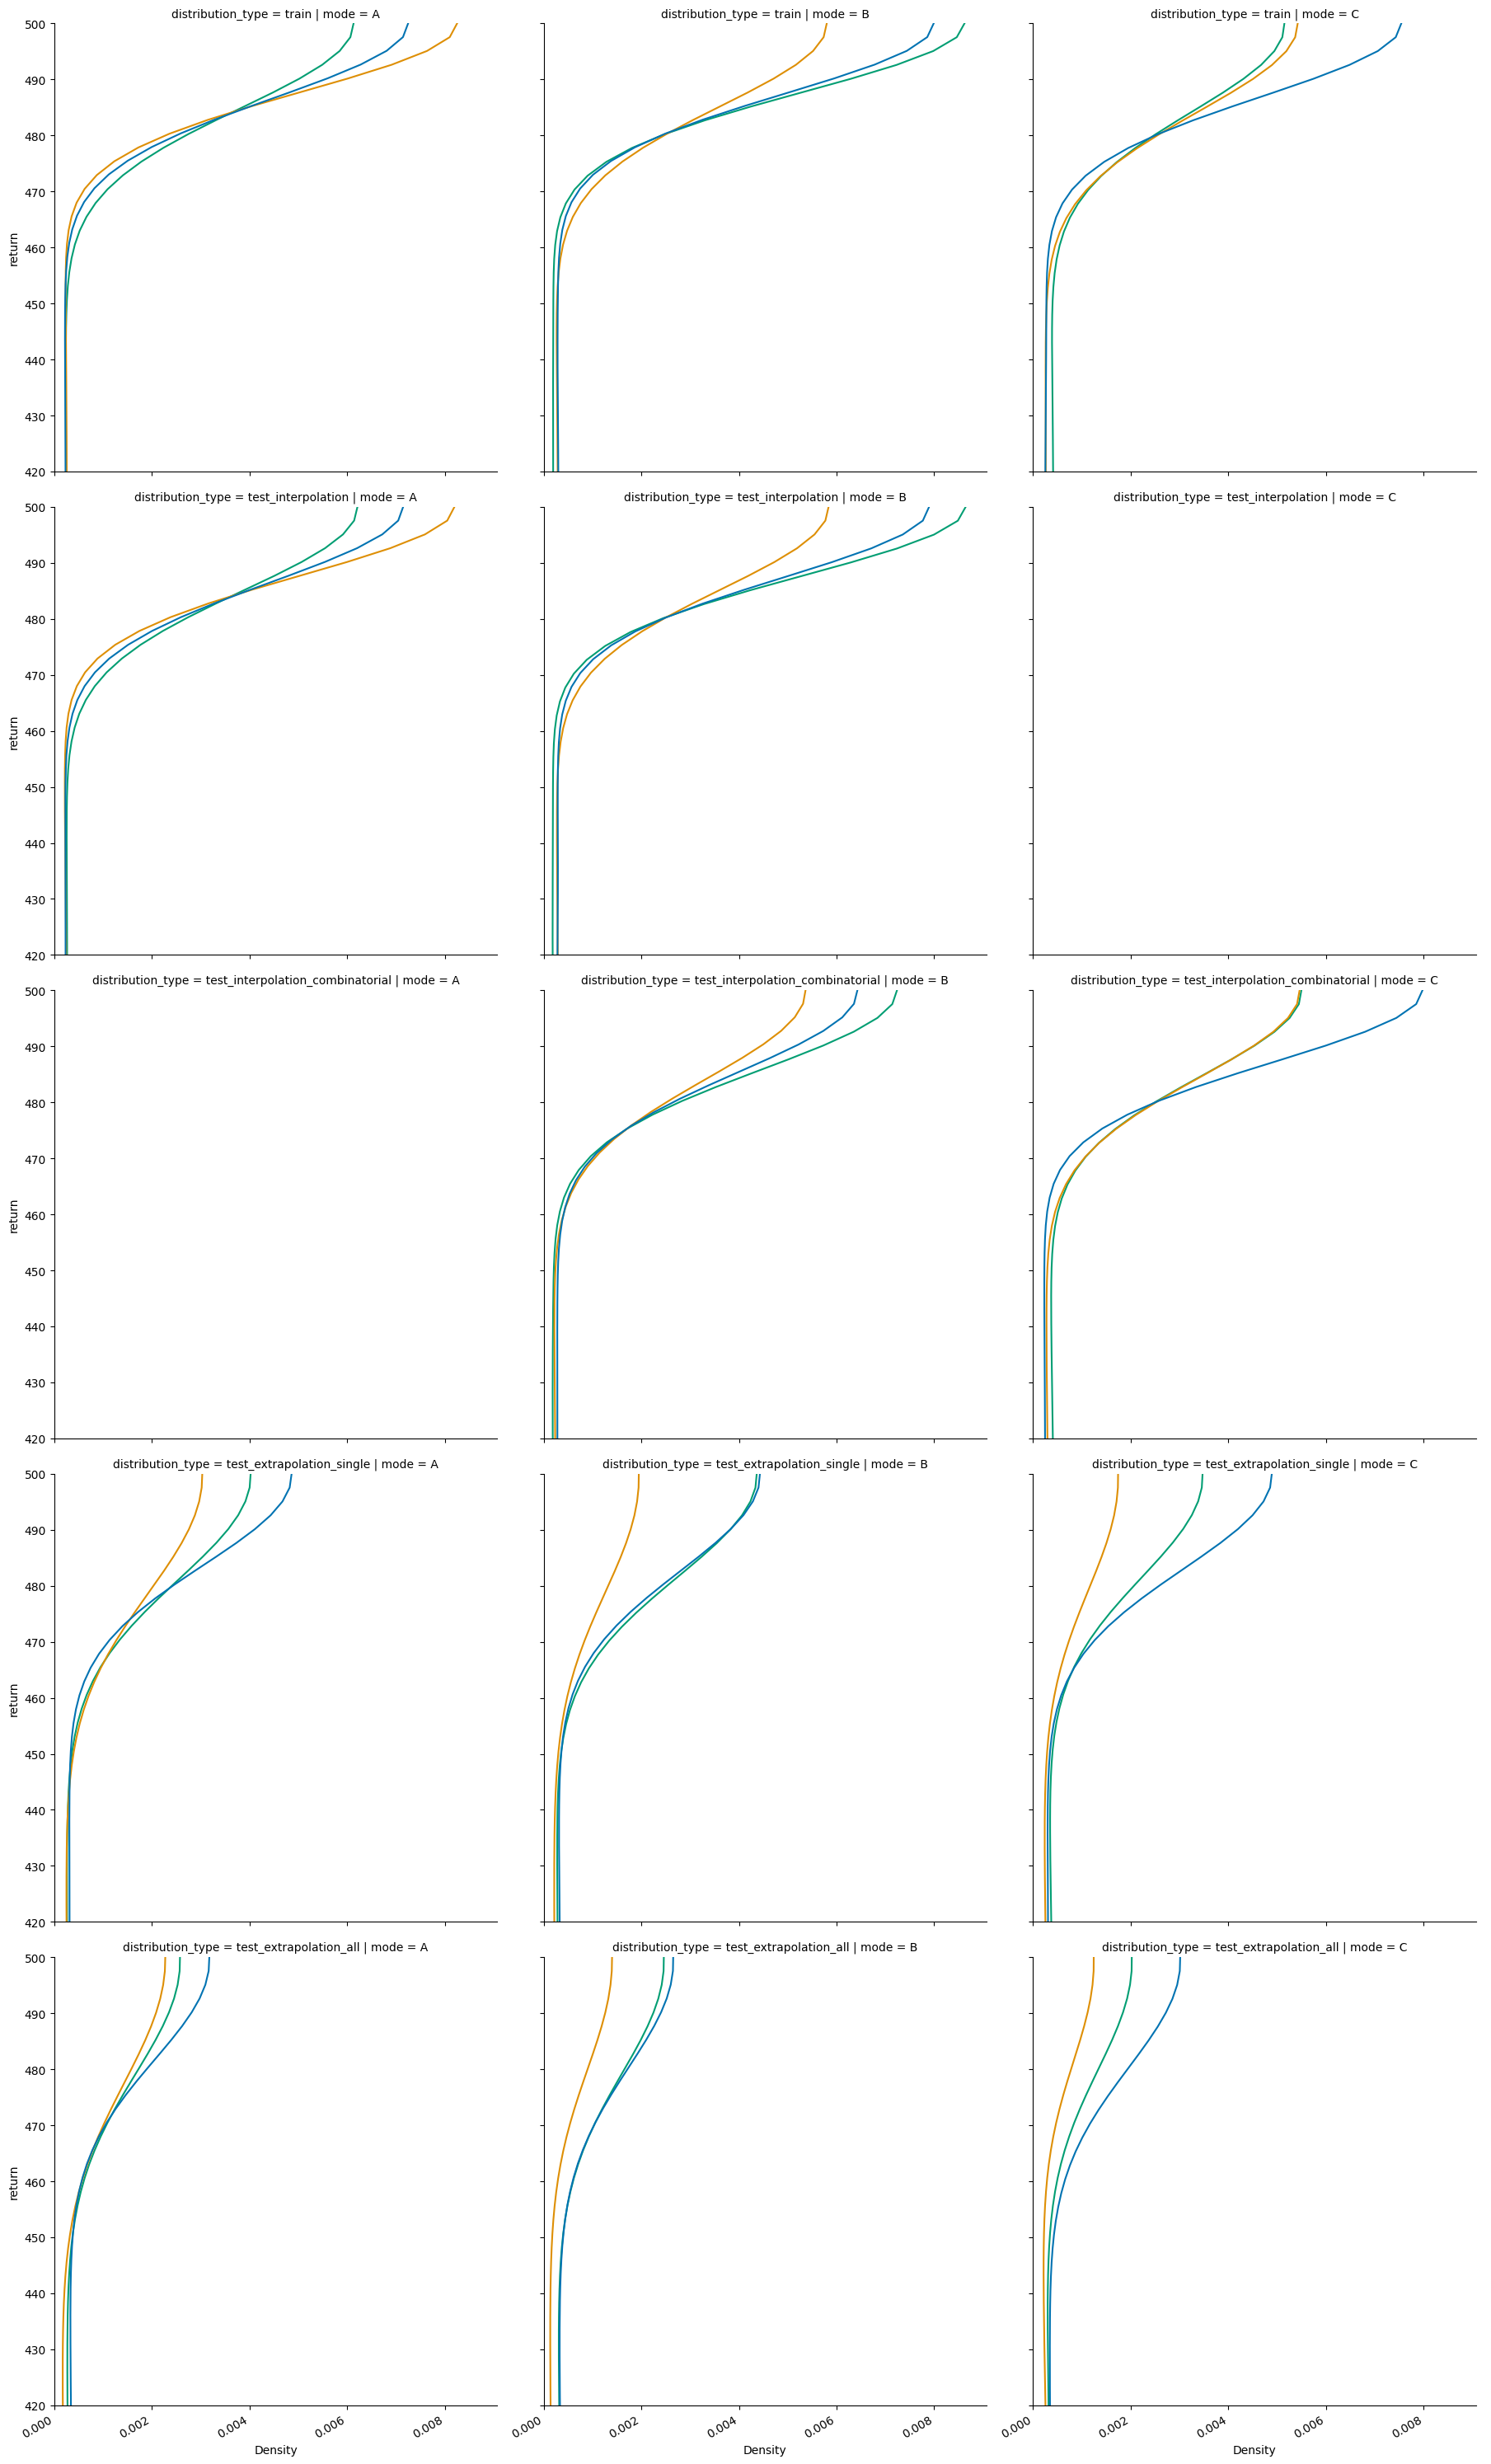

In [17]:
df = df_rpc
grid = sns.FacetGrid(df, col="mode", row="distribution_type", height=6, legend_out=True)
grid.map_dataframe(
    sns.kdeplot,
    y="return",
    hue="visibility",
    palette="colorblind",
    cut=0,
)
grid.set(ylim=(420, 500))
for axes in grid.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30, horizontalalignment="right")
grid.add_legend()
grid.figure.set_tight_layout(True)
plt.show()